### If this is your first encounter with ELFI, we recommend that you start with the ELFI_tutorial notebook.

# Automatic parallelization with ipyparallel

Behind the scenes, ELFI can automatically parallelize (most of) the computational inference by using a parallel client. The parallelization can be tuned with the keyword argument `batch_size` for the Rejection class, which tells how many "runs" should be sent to each available computational unit at a time. There is some overhead involved in the parallelization, so batches should be large, but not too large to eat all your memory (also remember that in a shared-memory system this precious resource is shared among the workers). 

Depending on your configuration, Numpy may be able to parallelize some of these operations as well. Note that the default client (`elfi.clients.native`) only parallelizes as much as NumPy allows. 

Currently ELFI supports also [_ipyparallel_](http://ipyparallel.readthedocs.io/), which allows both parallel and distributed computing. To set it as the client, you have to `import elfi.clients.ipyparallel` and then start (and finally stop) the responsible controller and engines. Below is an example of how to do this inside the Jupyter notebook running in a Unix-like operating system. Please see the [ipyparallel documentation](http://ipyparallel.readthedocs.io/en/latest/intro.html) for more info and details.

**Note:** this notebook demonstrates how to enable parallelization for the rejection sampling ABC algorithm, which is an example of [embarrassingly parallel](https://en.wikipedia.org/wiki/Embarrassingly_parallel) computing: each simulation is completely independent. Such algorithms highly benefit from parallelization.

Some other algorithms depend heavily on previous results, which makes them much harder to parallelize in a meaningful way. When considering an algorithm and its requirements for computional resources, one should always check its documentation. However, the following procedure should work regardless of whether the algorithm can parallelize or not.

### Starting ipcluster

Taking advantage of ipyparallel requires that you have an Ipyparallel controller and engines. You can achieve that with the following command (the exclamation mark is a Jupyter syntax for executing shell commands):

In [1]:
!ipcluster start -n 4 --daemon

This starts 1 Ipyparallel controller and 4 engines (workers) on a single host. The `daemon` option makes Ipyparallel run in the background, which is necessary in the notebook environment. This however means that one should remember to `stop` the ipcluster once it's no longer needed (see [bottom](#Remember-to-stop-the-ipcluster-when-done) of this notebook). 

One may also run the command in a separate terminal window, which is beneficial for debugging. For more options and details on Ipyparallel, please see its [documentation](http://ipyparallel.readthedocs.io).

In [2]:
# This is here just to ensure that ipcluster has started properly before continuing
import time
time.sleep(10)

### Parallel inference with ELFI

Now we can proceed to importing ELFI. It is important that all imports and definitions are visible to all Ipyparallel engines, which may be less trivial in some distributed environments. Here it suffices that *ELFI has been installed*, or added to the `PYTHONPATH`.

In [3]:
import elfi

ELFI is told to use the ipyparallel client by importing it:

In [4]:
import elfi.clients.ipyparallel

The MA2 model described and built in the basic ELFI tutorial is available for importing under `elfi.examples`:

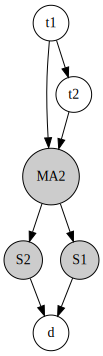

In [5]:
from elfi.examples import ma2
model = ma2.get_model()

elfi.draw(model)

Otherwise everything should be familiar, and ELFI handles everything for you regarding the parallelization. 

In [6]:
rej = elfi.Rejection(model, 'd', batch_size=10000)

When running the next command, take a look at the system monitor of your operating system; it should show 4 (or whatever number you gave the `ipcluster start` command) Python processes doing heavy computation simultaneously.

In [7]:
%time result = rej.sample(5000, quantile=0.001)  # 5 * 10^6 simulations

CPU times: user 3.55 s, sys: 334 ms, total: 3.89 s
Wall time: 21.4 s


The `Result` object is also just like in the basic case:

In [8]:
result.summary

Method: Rejection
Number of posterior samples: 5000
Number of simulations: 5000000
Threshold: 0.0382
Posterior means: t1: 0.767, t2: 0.248


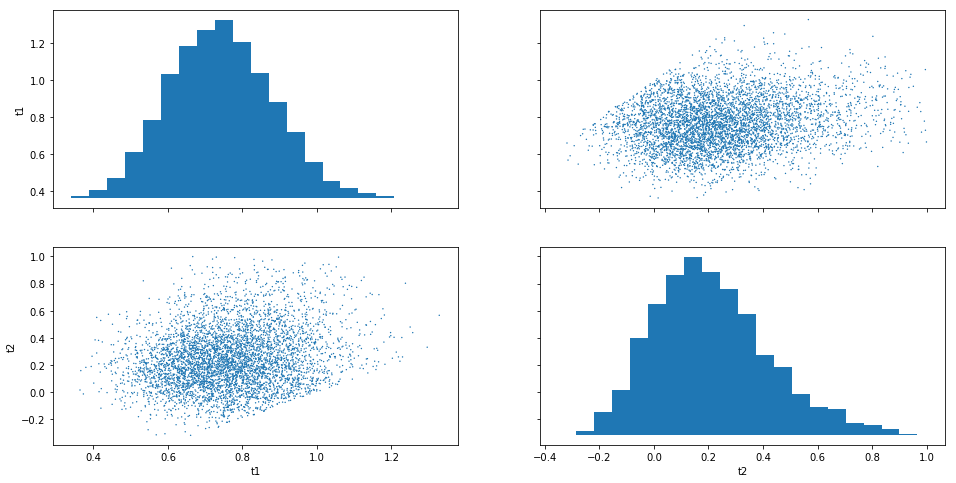

In [9]:
result.plot_pairs();

To summarize, the only thing that needed to be changed from the basic scenario was enabling the `ipyparallel` client.

### Functions in Jupyter and Ipyparallel

All imports and definitions must be visible for all Ipyparallel engines. This means that customizing the model from within the notebook has some caveats.

You can change the model with built-in functionality like this without problems:

In [10]:
d2 = elfi.Distance('cityblock', model['S1'], model['S2'], p=1)

rej2 = elfi.Rejection(d2, batch_size=10000)
result2 = rej2.sample(1000, quantile=0.01)

But let's say you want to use your very own distance:

In [11]:
def my_distance(x, y):
    return np.sum((x-y)**2, axis=1)

This is not automatically visible for the engines:

In [12]:
d3 = elfi.Distance(my_distance, model['S1'], model['S2'])
rej3 = elfi.Rejection(d3, batch_size=10000)

result3 = rej3.sample(1000, quantile=0.01)  # this will fail!

RemoteError: AttributeError(Can't get attribute 'my_distance' on <IPython.core.interactiveshell.DummyMod object at 0x10c376160>)

The solution is to manually `push` the new definition, along with its name, as a dictionary to the Ipyparallel engines:

In [13]:
elfi.get_client().ipp_client[:].push({'my_distance': my_distance})

<AsyncResult: _push>

This may look a bit cumbersome, but it works:

In [14]:
result3 = rej3.sample(1000, quantile=0.01)  # now this should work

However, a simple solution to problems like this is to define your functions in external scripts (see `elfi.examples.ma2`).

### Remember to stop the ipcluster when done

In [15]:
!ipcluster stop

2017-05-18 13:39:07.706 [IPClusterStop] Stopping cluster [pid=28773] with [signal=<Signals.SIGINT: 2>]
